In [1]:
%pylab inline
#%env RPN_DEFNS=/home/nchaisueb/defns.rpn

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import subprocess
from sdds import SDDS

In [3]:
#import parmap
import hashlib
from functools import partial
import numpy as np
import time,sys,os
import scipy.stats
import subprocess,linecache,shlex
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.signal import hilbert, chirp
from scipy import interpolate

from io import StringIO
import pandas as pd
from scipy.optimize import minimize

In [4]:
#Display MA and DA

In [5]:
cmd0 = 'elegant 409a4e7e07a6ed02f61e8d53dd740fb8.ele > /dev/null'

In [6]:
process = subprocess.Popen(cmd0, shell=True, stdout=subprocess.PIPE)

In [18]:
def MADAcal():
        
        m = hashlib.md5()
        src = str(time.time_ns())+str(np.random.rand())
        m.update(src.encode('utf-8'))
        fname = m.hexdigest()

        fin = open("MADAplot_temp.dat", "rt")
        fout = open(fname+".ele", "wt")
        for line in fin:
            #read replace the string and write to output file
            if 'fnamelte' in line:
                line = line.replace('fnamelte', str(fname)+'.lte')
            if 'fname' in line:
                line = line.replace('fname', str(fname))
            if 'venergy' in line:
                line = line.replace('venergy', str(800))
            fout.write(line)
        fin.close()
        fout.close()
        
        fin = open("4cellQBA.dat", "rt")
        fout = open(fname+".lte", "wt")
        for line in fin:
            if 'VSH1' in line:
                line = line.replace('VSH1', 0)
            fout.write(line)
        fin.close()
        fout.close()
        
        #cmd0 = 'mpiexec -n 8 Pelegant '+ fname + '.ele > /dev/null'
        #cmd0 = 'elegant '+ fname + '.ele > /dev/null'
        #cmd0 = sbatch submit_pelegant.sh
        #!/bin/bash
        #
        #SBATCH --ntasks=120
        #SBATCH --cpus-per-task=1
        #
        #SBATCH --partition=localQ
        #
        # job name
        #SBATCH -J elegant
        #
        # filenames stdout and stderr - customise, include %j 
        #SBATCH -o elegant_%j.out
        #SBATCH -e elegant_%j.err
        #

        CONTAINER='oras://registry:5000/acc-tools/bact-containers/elegant:latest'

        export OPENBLAS_NUM_THREADS=1
        export OMP_NUM_THREADS=1

        apptainer exec --no-https $CONTAINER mpirun -np $SLURM_NTASKS Pelegant twiss-da.ele
        #apptainer exec --no-https $CONTAINER mpirun -np $SLURM_NTASKS Pelegant twiss-da.ele
        
        process = subprocess.Popen(cmd0, shell=True, stdout=subprocess.PIPE)
        process.wait()
        
        cmd1 ='sddsprintout '+fname+ '.twi -notitle -spreadsheet -para=dnu?/dp '
        result = subprocess.run(shlex.split(cmd1), stdout=subprocess.PIPE)
        chrom = result.stdout.split()
        chromx,chromy = float(chrom[1]), float(chrom[3])
        print("ChromX = "+str(chromx))
        print("ChromY = "+str(chromy))

        if os.path.isfile(fname + '.fma'):
            cmd2='sdds2stream '+ fname + '.fma -col=delta,x,y,nux,nuy,diffusionRate '
            result = subprocess.run(shlex.split(cmd2), stdout=subprocess.PIPE)
            output =result.stdout.split()
            output=np.array(output,dtype='float64').reshape((-1,6))
            
            dp = output[:,0]
            x = output[:,1]
            y = output[:,2]
            tunex = output[:,3]
            tuney = output[:,4]
            dr = output[:,5]
            MAout = np.array([dp,x,y,tunex,tuney,dr])

        cmd3 = 'rm -f '+ fname+ '.fma'
        process = subprocess.Popen(cmd3, shell=True, stdout=subprocess.PIPE)
        process.wait()

        cmd4 = 'rm -f '+ fname+ '.twi' +' && ' + 'rm -f '+ fname+ '.ele'+' && ' + 'rm -f '+ fname+ '.lte'
        process = subprocess.Popen(cmd4, shell=True, stdout=subprocess.PIPE)
        process.wait()
        

        return MAout

In [19]:
!rm -f *.ele && rm -f *.lte && rm -f *.twi && rm -f *.fma

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [20]:
#MA
import time

start = time.time()
MAout1 = MADAcal()
end = time.time()
print(end - start)
np.savetxt('MAplot.txt', MAout1)

/bin/sh: 1: apptainer: not found
Error for sddsprintout:
Unable to open file "a4757a03da20ad5a7a727354ef7319e8.twi" for reading (SDDS_InitializeInput)


IndexError: list index out of range

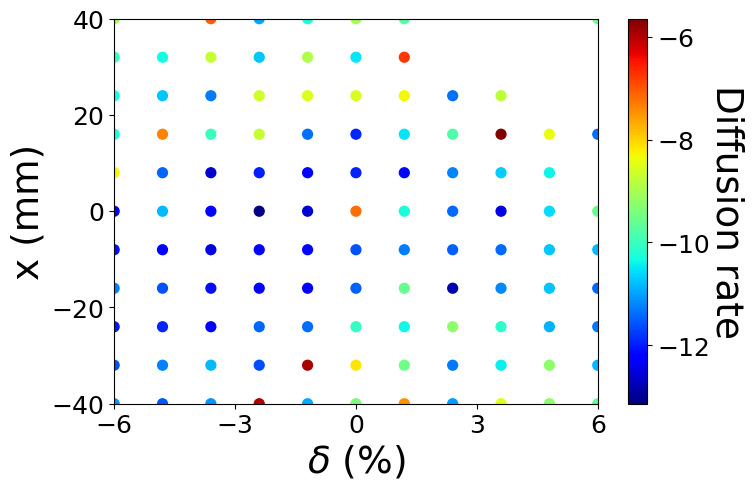

In [12]:
#MA
#MAout1= np.loadtxt('MAplot.txt')

plt.subplots(1,1,figsize = (7.8,5))
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.scatter(MAout1[0,:]*100,MAout1[1,:]*1000,c=MAout1[5,:],s=50,cmap='jet')
cbar=plt.colorbar()
cbar.set_label(label='Diffusion rate', rotation=270, fontsize =27,labelpad=25)
plt.xlabel('$\delta$ (%)',fontsize =27)
plt.ylabel('x (mm)',fontsize =27)
plt.xlim(-6,6)
plt.xticks([-6,-3,0,3,6])
plt.ylim(-40,40)
plt.yticks([-40,-20,0,20,40])
plt.savefig('MA.png',dpi = 300,bbox_inches='tight')
plt.show()

In [9]:
#DA
import time

start = time.time()
MAout2 = MADAcal()
end = time.time()
print(end - start)
np.savetxt('DAplot.txt', MAout2)

ChromX = 1.495241
ChromY = 1.46061
26284.833925008774


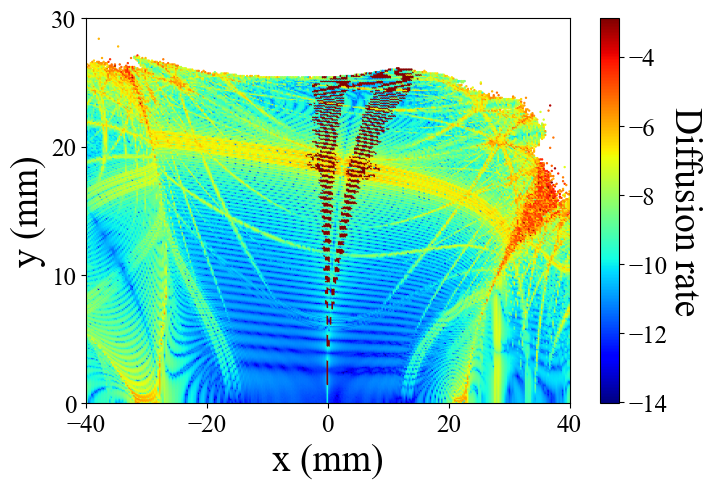

In [24]:
#DA
#MAout2= np.loadtxt('DAplot.txt')

plt.subplots(1,1,figsize = (7.8,5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
plt.scatter(MAout2[1,:]*1000,MAout2[2,:]*1000,c=MAout2[5,:],s=0.5,cmap='jet')
cbar=plt.colorbar()
cbar.set_label(label='Diffusion rate', rotation=270, fontsize =27,labelpad=25)
plt.xlabel('x (mm)',fontsize =27)
plt.ylabel('y (mm)',fontsize =27)
plt.xlim(-40,40)
plt.xticks([-40,-20,0,20,40])
plt.ylim(0,30)
plt.yticks([0, 10, 20, 30])
plt.savefig('DA.png',dpi = 300,bbox_inches='tight')
plt.show()

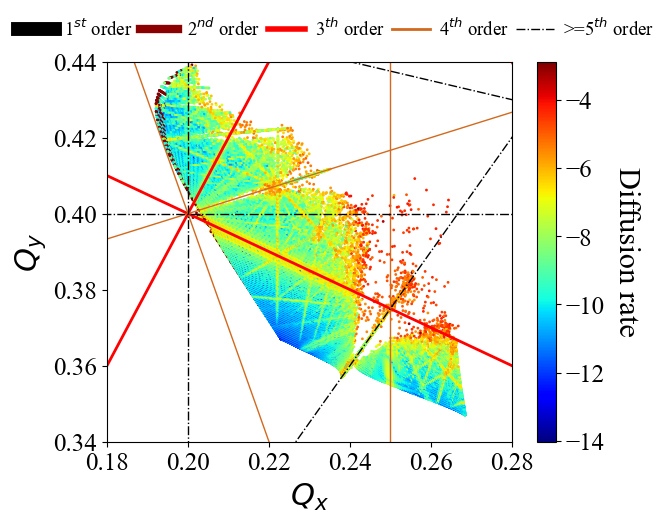

In [38]:
#FMA
MAout2= np.loadtxt('DAplot.txt')

import fractions as frac
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
fig=plt.figure(figsize =(7,5.5))

ax = fig.add_subplot(1,1,1)
#
#ax1 = fig.add_subplot(2,1,1)
#def updateOrder(lines,leftY,rightY,order,label):
#    if (leftY in lines):
#        if (rightY in lines[leftY]) and (lines[leftY][rightY]["order"]<order):
#            lines[leftY][rightY]={"order":order, "label":label}
#        else:
#            lines[leftY][rightY]={"order":order, "label":label}
#    else:
#        lines[leftY]={}
#        lines[leftY][rightY]={"order":order, "label":label}


def farey_gen(N):
    '''a generator to produce the ascending Farey sequence of order N,
    according to the algorithm described on
    http://en.wikipedia.org/wiki/Farey_sequence#Next_term'''

    a, b, c, d = 0, 1, 1, N
    yield frac.Fraction(a, b)
    while float(c)/d <= 1:
        k = (N+b)//d
        a, c = c, k*c-a
        b, d = d, k*d-b
        yield frac.Fraction(a, b)

def simplify(f1, f2, f3):
    '''simplify the linear equation
    f1*x + f2*y + f3 = 0
    to
    a*x + b*y + c = 0,
    where f1, f2 and f3 are irreducible fractions,
    a, b and c are coprime integers'''

    def lcd(a, b, c):
        '''lowest common denominator of three integers'''
        d = a * b / math.gcd(a, b)
        c =int(c)
        d =int(d)

        return int(c * d) / math.gcd(c, d)

    def gcd(a, b, c):
        '''greatest common divisor of three integers'''
        d = math.gcd(a, b)
        return math.gcd(c, d)

    d = lcd(f1.denominator, f2.denominator, f3.denominator)
    a = frac.Fraction(f1 * d).numerator
    b = frac.Fraction(f2 * d).numerator
    c = frac.Fraction(f3 * d).numerator
    d = gcd(a, b, c)
    return a/d, b/d

def sibling(line):
    '''find all the sibling of a line segment which have symmetric relation
    about the following axes: x = 1/2 or/and y = 1/2.
    The known line is given by a pair of points (4 coordinates).
    This function returns a set of point-pairs defining the related lines.'''

    lines = set([line])
    x1, y1, x2, y2 = line
    lines.add((1-x1, y1, 1-x2, y2))
    lines.add((x2, 1-y2, x1, 1-y1))
    lines.add((1-x2, 1-y2, 1-x1, 1-y1))
    return lines


def generatelines(N):
#N = int(raw_input("specify the order of the resonance: ")) # python3 -> input

#    ax1.clear()
    N=int(N)
    if N>0:
        Orders = range(1,N+1)
        fareys = [[] for x in Orders ]
        lines = [set() for x in Orders ]

    for Ni in range(len(Orders)):

        fareys[Ni] = [f for f in farey_gen(Orders[Ni])]
        lines[Ni] = set()

        # select line segments which belong to resonance of order N
        for i,f1 in enumerate(fareys[Ni]): # 0 <= f1 <= 1
            lines[Ni].add((f1, 0, f1, 1)) # vertical line
            lines[Ni].add((0, f1, 1, f1)) # horizontal line
            if f1 > 0 and 2*f1.denominator <= Orders[Ni]: # diagonal line, e.g. x + y - f1 = 0
                lines[Ni] = lines[Ni].union(sibling((f1, 0, 0, f1)))

            for f2 in fareys[Ni][1:i]: # 0 < f2 < f1
                a, b = simplify(1, abs(f2-f1), f1)
                if a + b <= Orders[Ni]: # e.g. x + (f2-f1)*y - f1 = 0
                    lines[Ni] = lines[Ni].union(sibling((f1, 0, f2, 1)))
                    lines[Ni] = lines[Ni].union(sibling((1, f2, 0, f1))) # flip about y = x

                a, b = simplify(f2, f1, f1*f2)
                if a + b <= Orders[Ni]: # e.g. f2*x + f1*y - f1*f2 = 0
                    lines[Ni] = lines[Ni].union(sibling((f1, 0, 0, f2)))
                    lines[Ni] = lines[Ni].union(sibling((f2, 0, 0, f1))) # flip about y = x

    lines=list(reversed(lines))

    if len(lines)>1:
        for i in range(len(lines)-1):
            lines[i] =lines[i].difference(lines[i+1])

    Ncount=1
    linecolors=['red',"deeppink","chocolate","blue",'black']
    #linecolors=['k',"k","k","k",'k']

    for x in list(reversed(lines)):
        while x:
            x1, y1, x2, y2 = x.pop()
            x1 = x1
            x2 = x2
            y1 = y1
            y2 = y2
            if Ncount==1:
                ax.plot([x1, x2], [y1, y2], linewidth=20,color='black')
            elif Ncount==2:
                ax.plot([x1, x2], [y1, y2], linewidth=5,color='darkred')
            elif Ncount==3:
                ax.plot([x1, x2], [y1, y2], linewidth=2,color='red')
            elif Ncount==4:
                ax.plot([x1, x2], [y1, y2], linewidth=1, color="chocolate")
            else:
                ax.plot([x1, x2], [y1, y2], linewidth=1, color='black',linestyle='-.')

        Ncount+=1
    #ax.plot([0, 0.5], [0.5, 0.5], linewidth=10,color='darkred')
    #ax.plot([0.5, 0.5], [0.0, 0.5], linewidth=10,color='darkred')
    #ax.set_xlabel("$Q_x$")
    #ax.set_ylabel("$Q_y$")
    #ax.set_title("tune diagram of order %d" % N)
#    ax1.set_xlim(xlim)
#    ax1.set_ylim(ylim)
    fig.canvas.draw()




generatelines(5)

#np.divide(10, Ncount)
#sc =ax.scatter(Fout[:,3],Fout[:,4], c=Fout[:,-1],marker='s',cmap='jet',s=12)
#ax.plot(cx,cy)
#ax.plot(rx,ry)
#for l in cbar.ax.yaxis.get_ticklabels():
#    l.set_fontsize(16)

#ax.legend(fontsize =14,loc=9)
#plt.tight_layout()

for tick in ax.get_yticklabels():
    #tick.set_fontname('Arial')
    #tick.set_fontsize(22)
    tick.set_color('k')

for tick in ax.get_xticklabels():
    #tick.set_fontname('Arial')
    #tick.set_fontsize(22)
    tick.set_color('k')

#ax.set_xticks(np.linspace(-10,10,5))
#ax.set_yticks(np.linspace(0,6,3))
#for tick in cbar.ax.get_yticklabels():
#    tick.set_fontname('Arial')
#    tick.set_fontsize(22)
#    tick.set_color('k')

ax.set_xlabel(r'$Q_x$',fontsize =22)
ax.set_ylabel(r'$Q_y$',fontsize =22)

#cbar.ax.get_yaxis().labelpad =19
#cbar.ax.set_ylabel('Diffusion Rate', rotation=270,fontsize =14)

#cbar.set_label('Diffusion rate',  y=0.52, rotation=270,fontsize =24,fontname="Arial")

custom_lines1 = [Line2D([0], [0], color= 'black', lw=10), Line2D([0], [0], color= 'darkred', lw=6), Line2D([0], [0], color= 'red', lw=4),
                   Line2D([0], [0], color= 'chocolate', lw=2),Line2D([0], [0], color= 'black', lw=1,linestyle='-.')]


#ax21.legend(custom_lines, ['Bend', 'Quadrupole', 'Sextupole','Octupole'])
ax.legend(custom_lines1, [r'1$^{st}$'+' order',r'2$^{nd}$'+' order',r'3$^{th}$'+' order',r'4$^{th}$'+' order','>='+r'5$^{th}$'+' order'],ncol=5, loc='upper center',prop={'size': 13.5},bbox_to_anchor=(0.5,0.98),bbox_transform=plt.gcf().transFigure,frameon=False,handletextpad=0.5,columnspacing=0.4)

#ax.text(0.00, -0.115, '(b)', transform=ax.transAxes,
#            size=22, weight='normal',color = 'k')
    
plt.scatter(MAout2[3,:],MAout2[4,:],c=MAout2[5,:],s=1,cmap='jet')
cbar=plt.colorbar()
cbar.set_label(label='Diffusion rate', rotation=270, fontsize =22,labelpad=25)

Qxx = 4.166578989297326
Qyy = 3.2358403327717493
#sc1 = ax.scatter(Qxx/5, Qyy/5, marker='o',color='b',s=150)
#sc2 = ax.scatter(Qxx%1, Qyy%1, marker='^',color='b',s=150)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlim([0.18,0.28])
ax.set_xticks([0.18,0.20,0.22,0.24,0.26,0.28])
ax.set_ylim([0.34,0.44])
ax.set_yticks([0.34,0.36,0.38,0.40,0.42,0.44])
#ax.set_xlim([0.79,0.87])
#ax.set_xticks([0.79,0.81,0.83,0.85,0.87])
#ax.set_ylim([0.58,0.68])
#ax.set_xlim([0.12,0.24])
#ax.set_xticks([0.32,0.34,0.36,0.38,0.40])
#ax.set_ylim([0.06,0.26])
#ax.set_yticks([0.06,0.1,0.14,0.18,0.22,0.26])
plt.tight_layout()

fig.savefig('FMA.png',dpi = 300,bbox_inches='tight')

In [64]:
Xin_import = np.loadtxt('newDBATSX10.txt')
print(Xin_import[192])
print(0.25+Xin_import[192][4])
print(0.30109905050673815-Xin_import[192][4])

[ 9.33454208e+00 -1.02942397e+01 -1.15242900e+02  7.95404558e+01
  1.08145723e-06]
0.25000108145722794
0.3010979690495102


Text(0.5, 1.0, '800 MeV, 200 mA, 1% coupling, 500MHz, 100 bunches')

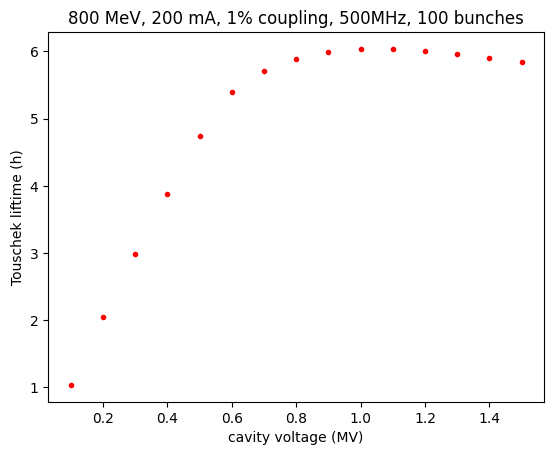

In [117]:
#Touschek lifetime
cav = np.linspace(0.1,1.5,15)
tau = [1.037,2.051,2.984,3.876,4.747,5.389,5.708,5.894,5.993,6.035,6.037,6.011,5.965,5.907,5.840]

plot(cav,tau,'r.')

xlabel('cavity voltage (MV)')
ylabel('Touschek liftime (h)')
title('800 MeV, 200 mA, 1% coupling, 500MHz, 100 bunches')